In [1]:
import sys
import os
project_path = '../../..'
sys.path.append(os.path.abspath(project_path))

In [2]:
from matplotlib import pyplot as plt
import numpy as np

# Load Synthetic Data

In [3]:
num_states = 3
emission_dist = 't'
save_path = '2020_3states'
folder_path = f"{project_path}/data/synthetic/{emission_dist}-hmm/{save_path}"
s_filename = f"{folder_path}/S_data.npy"
x_filename = f"{folder_path}/X_data.npy"
S = np.load(s_filename)
X = np.load(x_filename)

In [4]:
from data_code.dataloader import create_dataloaders, create_datasets

window_size = 390
batch_size = 32

train_loader, val_loader, test_loader = create_dataloaders(
    X, S, window_size=window_size, train_ratio=0.6, val_ratio=0.2, batch_size=batch_size, standardize=True, feature_engineer=True
)

# Search the Best Hyper-parameter for Jump Model

In [5]:
import optuna
import json
import os
from utils.metrics import balanced_accuracy
from model.jump_module import JumpModule

# Construct a grid for jump_penalty using logarithmic uniform spacing
grid_values = np.logspace(-3, 5, 17).tolist()  # Generate values from 1e-3 to 1e5 in log-uniform spacing

def objective(trial):
    # Select a jump_penalty value from the pre-defined grid
    jump_penalty = trial.suggest_categorical("jump_penalty", grid_values)
    
    # Construct and train the model using the selected hyperparameter
    jump = JumpModule(num_states, jump_penalty=jump_penalty, max_iter=100)
    jump.fit(train_loader)
    true_s_val, pred_s_val = jump.inference(val_loader)
    val_bal_acc = balanced_accuracy(true_s_val.ravel(), pred_s_val.ravel(), n_classes=num_states)
    
    return val_bal_acc

# Define the search space
search_space = {"jump_penalty": grid_values}
# Use GridSampler to perform grid search
sampler = optuna.samplers.GridSampler(search_space)

# Create an Optuna Study and set the direction to maximize Balanced Accuracy
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective)

# Output the best hyperparameters
print("Best trial:")
best_trial = study.best_trial
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

# Save the best hyperparameters to a file
best_params = best_trial.params

os.makedirs(f"{project_path}/hyper_parameter/best_jump", exist_ok=True)
param_file_name = f"{project_path}/hyper_parameter/best_jump/{save_path}.json"
with open(param_file_name, "w") as f:
    json.dump(best_params, f, indent=4)

print(f"Best hyperparameters saved to '{param_file_name}'.")


[I 2025-03-24 11:49:22,752] A new study created in memory with name: no-name-3e80d06d-79cb-4134-8951-ae85f7bcb9c0
[I 2025-03-24 11:50:09,457] Trial 0 finished with value: 0.581259268811242 and parameters: {'jump_penalty': 0.0031622776601683794}. Best is trial 0 with value: 0.581259268811242.
[I 2025-03-24 11:50:58,847] Trial 1 finished with value: 0.5774349383516505 and parameters: {'jump_penalty': 1.0}. Best is trial 0 with value: 0.581259268811242.
[I 2025-03-24 11:51:51,804] Trial 2 finished with value: 0.5802571396145334 and parameters: {'jump_penalty': 10.0}. Best is trial 0 with value: 0.581259268811242.
[I 2025-03-24 11:52:44,320] Trial 3 finished with value: 0.6103004558510688 and parameters: {'jump_penalty': 31.622776601683793}. Best is trial 3 with value: 0.6103004558510688.
[I 2025-03-24 11:53:30,381] Trial 4 finished with value: 0.46386867834676737 and parameters: {'jump_penalty': 3162.2776601683795}. Best is trial 3 with value: 0.6103004558510688.
[I 2025-03-24 11:54:16,91

Best trial:
  jump_penalty: 31.622776601683793
Best hyperparameters saved to '../../../hyper_parameter/best_jump/2020_3states.json'.


In [6]:
# Load the best hyper-parameter
with open(param_file_name, "r") as f:
    loaded_params = json.load(f)

print("Loaded hyperparameters:")
print(loaded_params)

jump = JumpModule(num_states, jump_penalty=loaded_params['jump_penalty'], max_iter=100)
jump.fit(train_loader)

true_s_train_jump, pred_s_train_jump = jump.inference(train_loader)
true_s_test_jump, pred_s_test_jump = jump.inference(test_loader)

jump_bal_acc_train = balanced_accuracy(true_s_train_jump.ravel(), pred_s_train_jump.ravel(), n_classes = num_states)
jump_bal_acc_test = balanced_accuracy(true_s_test_jump.ravel(), pred_s_test_jump.ravel(), n_classes = num_states)
print(f"[Jump] Balanced Accuracy [train]: {jump_bal_acc_train:.4f}")
print(f"[Jump] Balanced Accuracy [test]: {jump_bal_acc_test:.4f}")

Loaded hyperparameters:
{'jump_penalty': 31.622776601683793}
[Jump] Balanced Accuracy [train]: 0.6053
[Jump] Balanced Accuracy [test]: 0.6195


# Gaussian HMM

In [7]:
from model.hmm_module import GaussianHMMModule

hmm_model = GaussianHMMModule(n_components=num_states, covariance_type='full', n_iter=100, random_state=42)
hmm_model.fit(train_loader)
true_s_train_hmm, pred_s_train_hmm = hmm_model.inference(train_loader)
true_s_test_hmm, pred_s_test_hmm = hmm_model.inference(test_loader)

# Evaluation
hmm_bal_acc_train = balanced_accuracy(true_s_train_hmm.ravel(), pred_s_train_hmm.ravel(), n_classes = num_states)
hmm_bal_acc_test = balanced_accuracy(true_s_test_hmm.ravel(), pred_s_test_hmm.ravel(), n_classes = num_states)
print(f"[HMM] Balanced Accuracy [train]: {hmm_bal_acc_train:.4f}")
print(f"[HMM] Balanced Accuracy [test]: {hmm_bal_acc_test:.4f}")

[HMM] Balanced Accuracy [train]: 0.3335
[HMM] Balanced Accuracy [test]: 0.3333


# KMeans++

In [8]:
from model.kmeans_module import KMeansModule

kmeans = KMeansModule(n_clusters=num_states, n_init=10, max_iter=300)
kmeans.fit(train_loader)

true_s_train_kmeans, pred_s_train_kmeans = kmeans.inference(train_loader)
true_s_test_kmeans, pred_s_test_kmeans = kmeans.inference(test_loader)

kmeans_bal_acc_train = balanced_accuracy(true_s_train_kmeans.ravel(), pred_s_train_kmeans.ravel(), n_classes = num_states)
kmeans_bal_acc_test = balanced_accuracy(true_s_test_kmeans.ravel(), pred_s_test_kmeans.ravel(), n_classes = num_states)
print(f"[KMeans] Balanced Accuracy [train]: {kmeans_bal_acc_train:.4f}")
print(f"[KMeans] Balanced Accuracy [test]: {kmeans_bal_acc_test:.4f}")

[KMeans] Balanced Accuracy [train]: 0.5817
[KMeans] Balanced Accuracy [test]: 0.5953


# Visualization

In [36]:
from utils.visualize import plot_clusters

num = 10

x_all = []
for x_batch, _ in test_loader:
    x_all.append(x_batch)
x_all = np.concatenate(x_all)

original_embed = x_all[:num].reshape(-1, x_all.shape[-1])

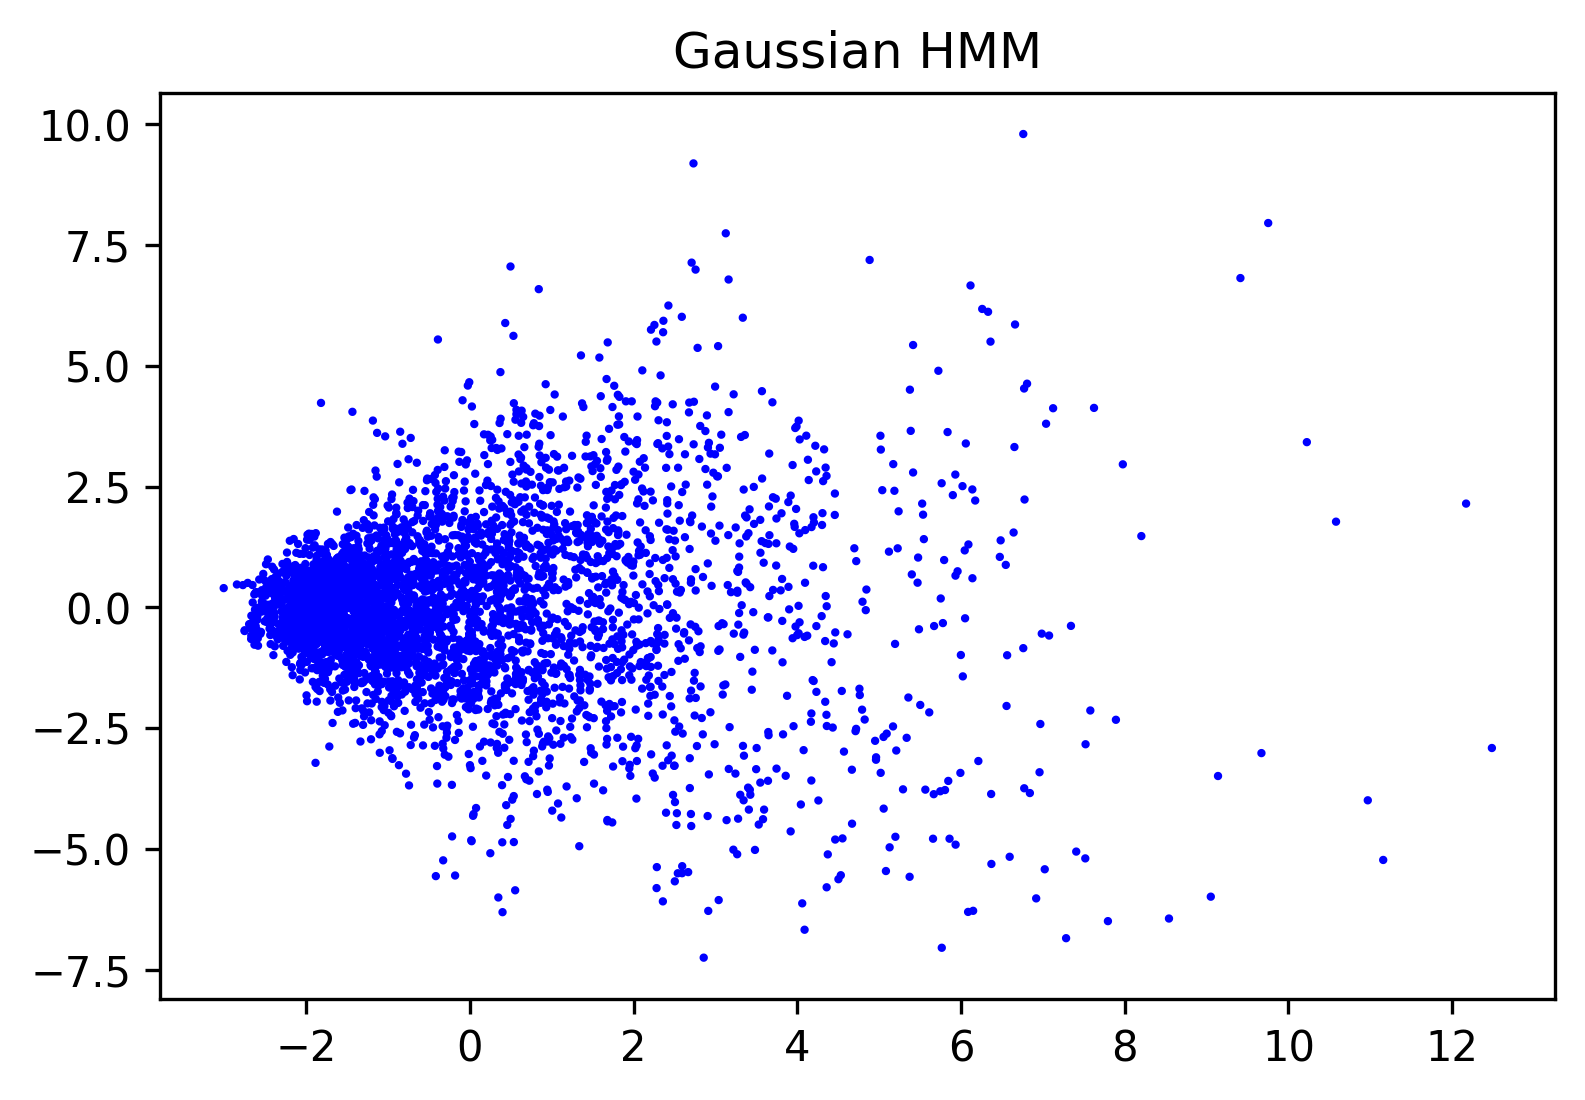

In [31]:
plot_clusters(
    data=original_embed,        
    cluster_labels=pred_s_test_hmm[:num].ravel(),
    cluster_count=num_states,
    colors=['red', 'green', 'blue'],
    label_names=None,
    pca_components=2,
    title='Gaussian HMM',
    save_path=f"{project_path}/figures/{save_path}/Gaussian_HMM.png",
    dpi=300,
    marker_size=1,
    legend=False
)

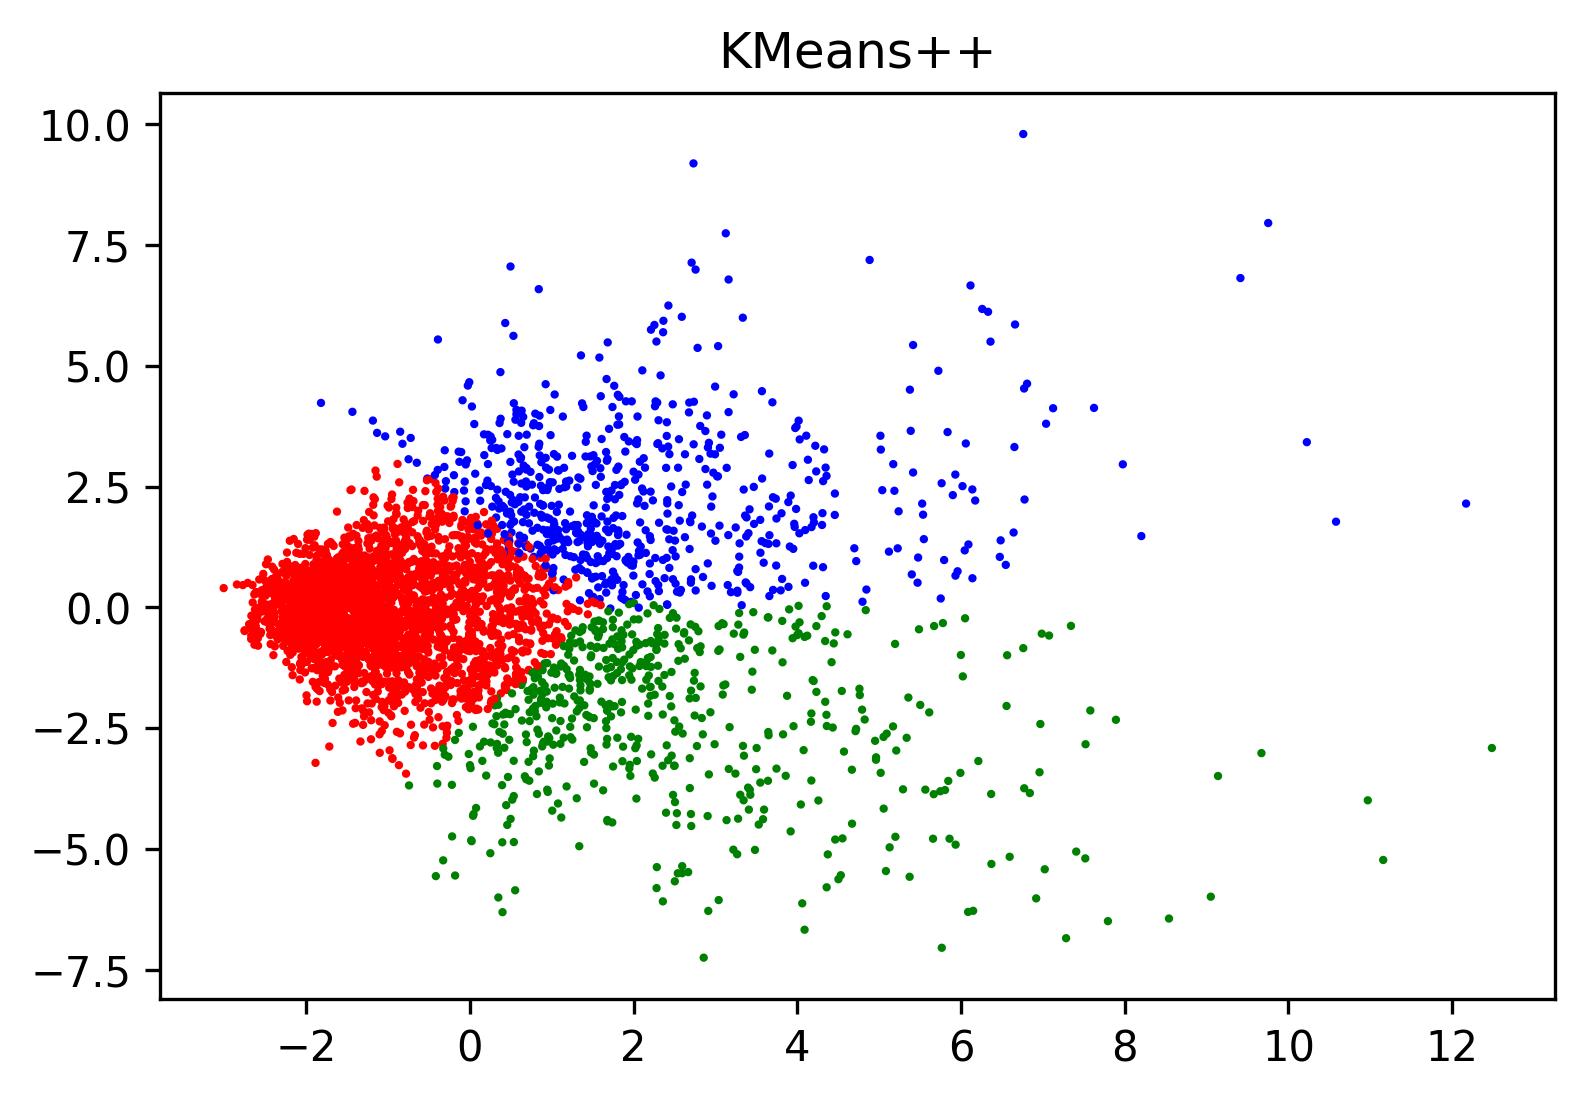

In [32]:
plot_clusters(
    data=original_embed,        
    cluster_labels=pred_s_test_kmeans[:num].ravel(),
    cluster_count=num_states,
    colors=['green', 'blue', 'red'],
    label_names=None,
    pca_components=2,
    title='KMeans++',
    save_path=f"{project_path}/figures/{save_path}/KMeans++.png",
    dpi=300,
    marker_size=1,
    legend=False
)

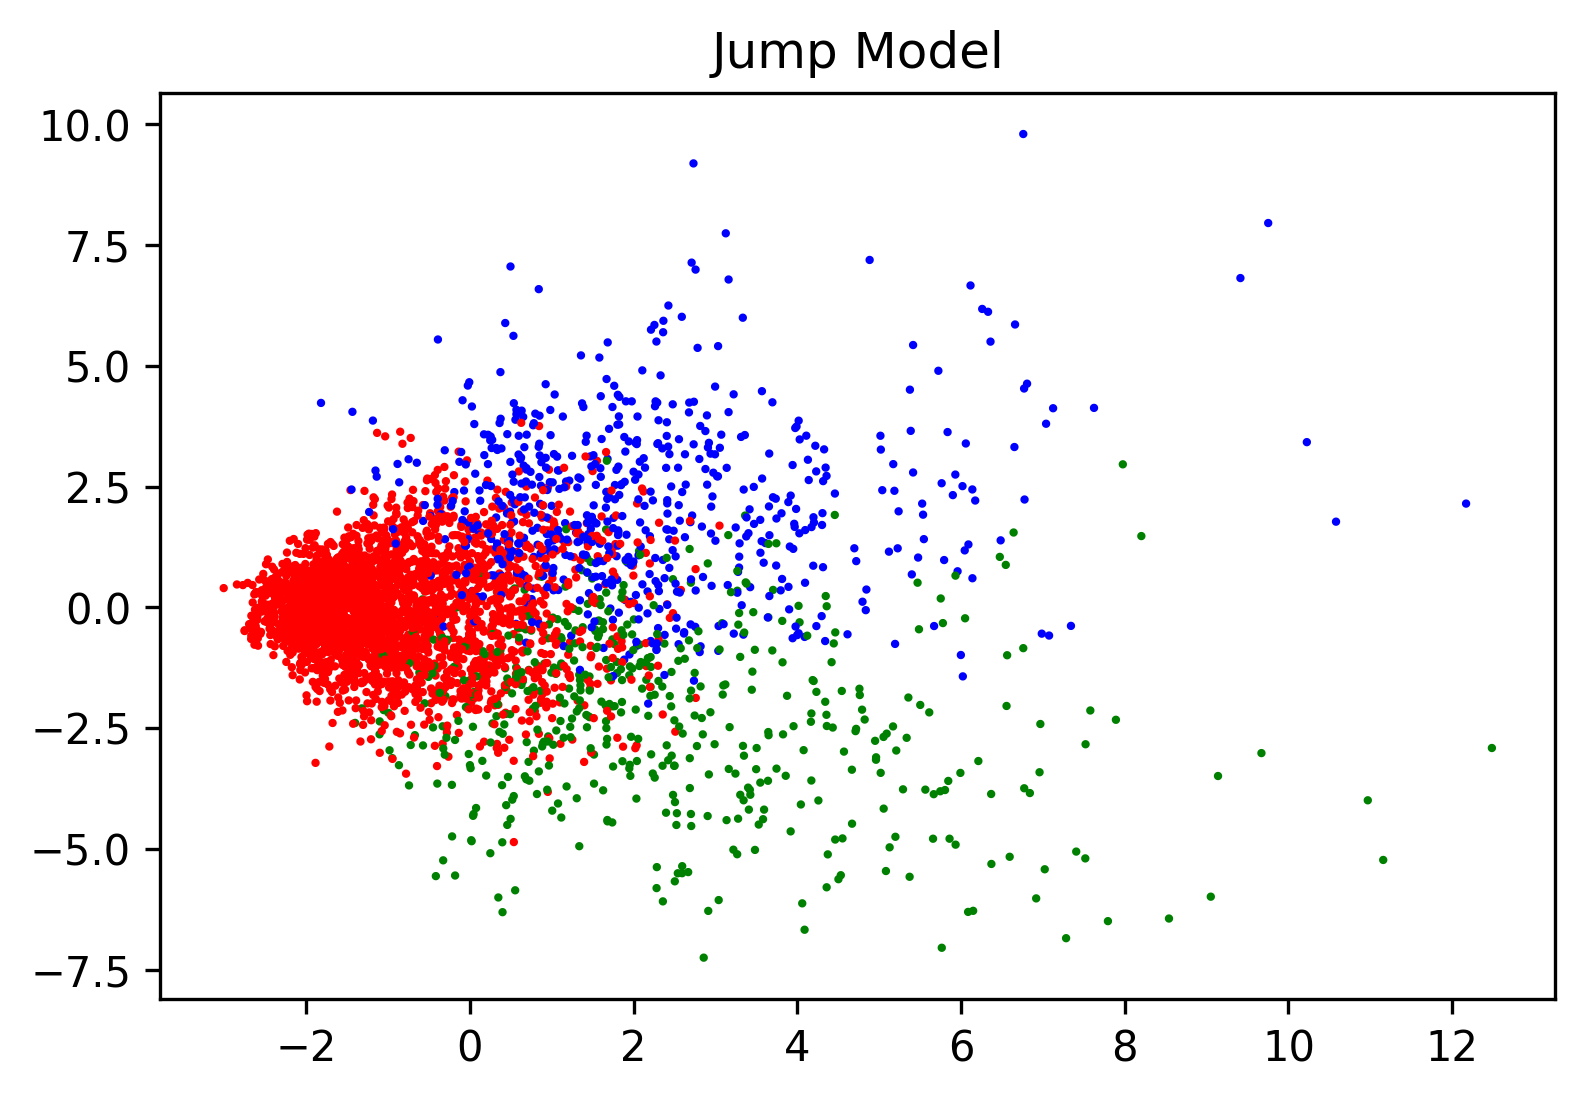

In [33]:
plot_clusters(
    data=original_embed,        
    cluster_labels=pred_s_test_jump[:num].ravel(),
    cluster_count=num_states,
    colors=['red', 'green', 'blue'],
    label_names=None,
    pca_components=2,
    title='Jump Model',
    save_path=f"{project_path}/figures/{save_path}/Jump_Model.png",
    dpi=300,
    marker_size=1,
    legend=False
)

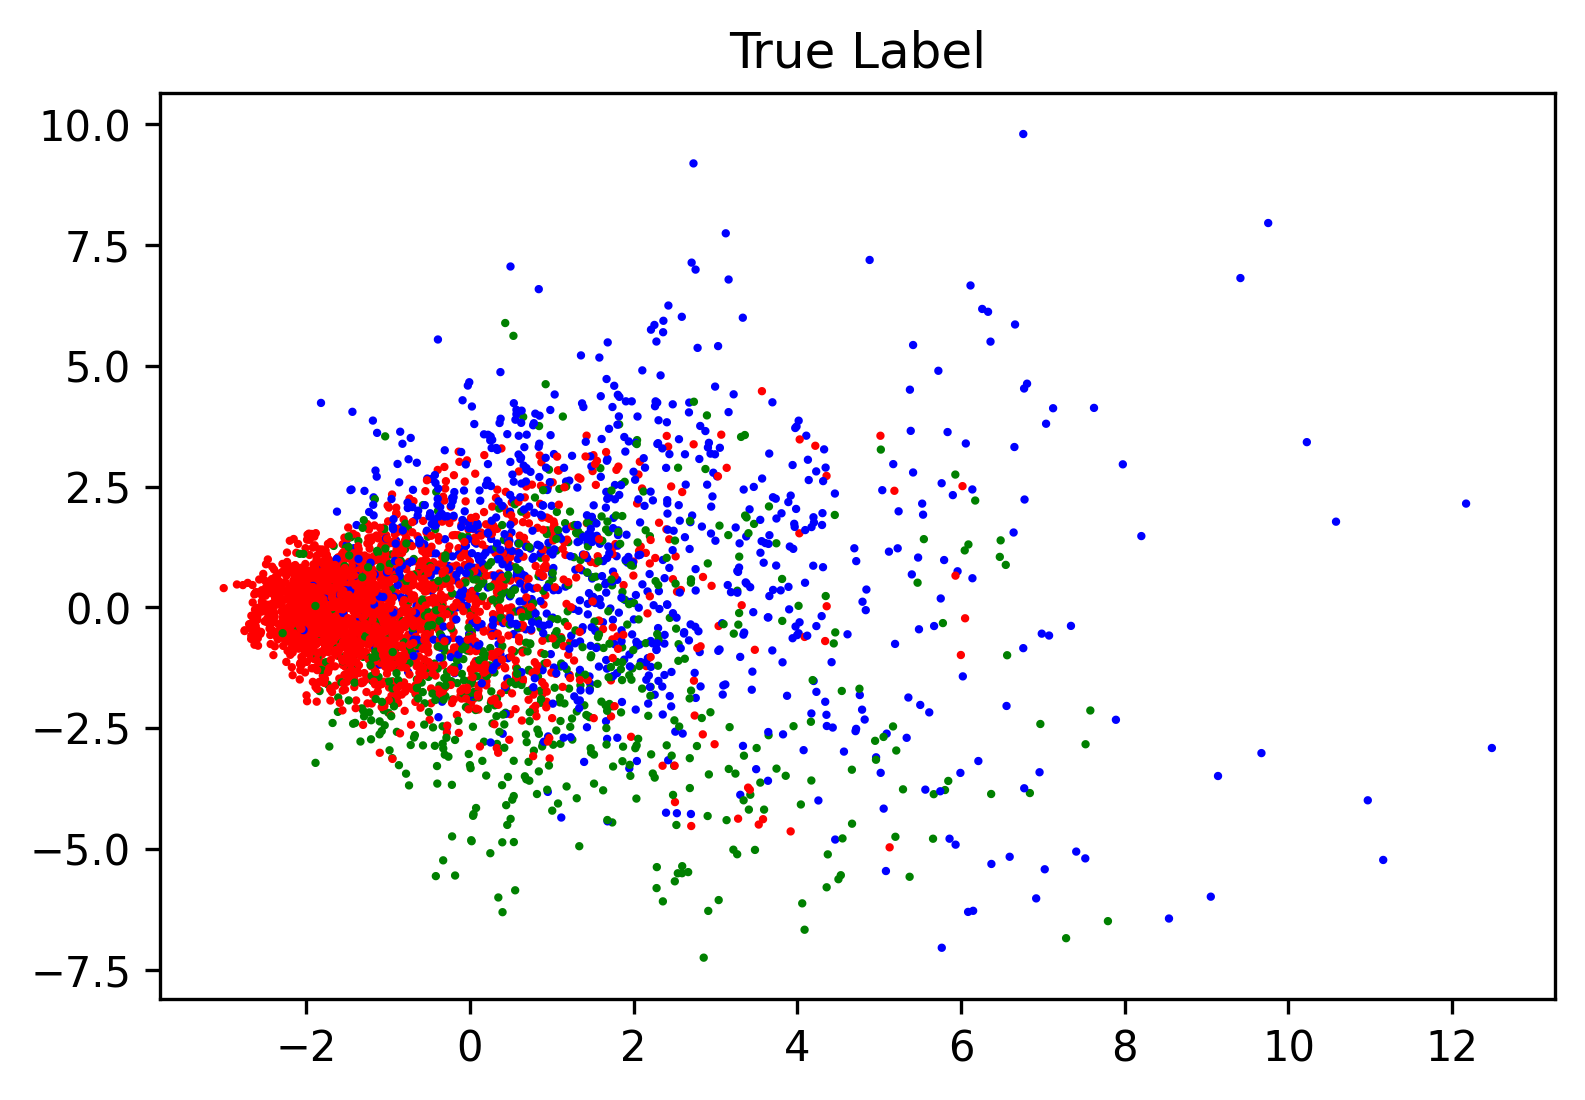

In [34]:
plot_clusters(
    data=original_embed,        
    cluster_labels=true_s_test_hmm[:num].ravel(),
    cluster_count=num_states,
    colors=['green', 'red', 'blue'],
    label_names=None,
    pca_components=2,
    title='True Label',
    save_path=f"{project_path}/figures/{save_path}/True.png",
    dpi=300,
    marker_size=1,
    legend=False
)